# Accel‑Align: a fast sequence mapper and aligner based on the seed–embed–extend method

Presented by Brian Palmer

## Background

### What is an alignment?

A process where we take each *read* and figure out where it fits in a *reference genome*

*Read* - a sequence of base pairs that *should* correspond to a DNA fragment.

*Reference Genome* - the target sequence of base pairs that we would like to compare our DNA fragment with.

Abstractly, this is a **string matching** problem.

### We've all done some form of string matching

In [11]:
ref_genome = 'GATACA'
read = 'TAC'
ref_genome.find(read)

2

In [12]:
def find_substring(read, ref_genome):
    '''
    Return the position of the read in the genome
    with this naive approach.
    
    NOTE: position is zero-based
    '''
    
    bound_check = 0
    for position, genome_basepair in enumerate(ref_genome):
        if genome_basepair == read[bound_check]: 
            bound_check += 1     
        else: bound_check = 0
            
        if bound_check == len(read): 
            return position - len(read) + 1
    
    return -1    


ref_genome = 'GATACA'
read = 'TAC'
find_substring(read, ref_genome)


2

### Why do most aligners not take this approach

Does not take into account:

1. Differences between the read and the reference genome (SNPs, other polymorphisms)
2. Sequencing errors (Substitutions, INDELs)

Therefore, we cannot rely on **exact** matches. We need to account for differences and errors.

### Popular string matching distance algorithms

#### Levenshtein Distance

* Used by *gapped* (allow indels) aligners:
    * Bowtie2
    * BWA-MEM
    * Minimap2

In [13]:
import numpy as np

def levenshtein_distance(read, ref_genome_fragment, print_matrix=True):
    '''
    Brief:
    
    A gapped aligner that counts the differences between two strings 
    allowing insertions and deletions.
    
    Useful comparing string with INDEL errors and substitutions.
    
    Adapted from rf. https://en.wikipedia.org/wiki/Levenshtein_distance
    '''
    
    if print_matrix: print(f"rows: {read}\ncolumns: {ref_genome_fragment}")
    
    matrix = np.zeros([len(read) + 1, len(ref_genome_fragment) + 1])
        
    for i in range(len(read) + 1):
        matrix[i][0] = i
    
    for i in range(len(ref_genome_fragment) + 1):
        matrix[0][i] = i
            
    for idx_r, read_basepair in enumerate(read):   
        idx_r += 1
        for idx_g, genome_basepair in enumerate(ref_genome_fragment):
            idx_g += 1
            if read_basepair == genome_basepair:
                matrix[idx_r][idx_g] = matrix[idx_r - 1][idx_g - 1]
            else:
                matrix[idx_r][idx_g] = min(
                    matrix[idx_r][idx_g - 1] + 1, 
                    matrix[idx_r - 1][idx_g] + 1, 
                    matrix[idx_r - 1, idx_g - 1] + 1)

                
    if print_matrix: print(matrix)
        
    return matrix[len(read), len(ref_genome_fragment)]



In [14]:
help(levenshtein_distance)

# TODO: Update this with your own strings!
levenshtein_distance('CTGA', 'TGA')

Help on function levenshtein_distance in module __main__:

levenshtein_distance(read, ref_genome_fragment, print_matrix=True)
    Brief:
    
    A gapped aligner that counts the differences between two strings 
    allowing insertions and deletions.
    
    Useful comparing string with INDEL errors and substitutions.
    
    Adapted from rf. https://en.wikipedia.org/wiki/Levenshtein_distance

rows: CTGA
columns: TGA
[[0. 1. 2. 3.]
 [1. 1. 2. 3.]
 [2. 1. 2. 3.]
 [3. 2. 1. 2.]
 [4. 3. 2. 1.]]


1.0

In [15]:
levenshtein_distance('kitten', 'sitting') # from the wikipedia example

rows: kitten
columns: sitting
[[0. 1. 2. 3. 4. 5. 6. 7.]
 [1. 1. 2. 3. 4. 5. 6. 7.]
 [2. 2. 1. 2. 3. 4. 5. 6.]
 [3. 3. 2. 1. 2. 3. 4. 5.]
 [4. 4. 3. 2. 1. 2. 3. 4.]
 [5. 5. 4. 3. 2. 2. 3. 4.]
 [6. 6. 5. 4. 3. 3. 2. 3.]]


3.0


**k**itt**e**n**-**</br>
**s**itt**i**n**g**</br>
**1** -> 1 -> 1 -> 1 -> **2** -> 2 -> **3** 

#### Hamming Distance

In [16]:
def hamming_distance(read, ref_genome):
    '''
    Find the number of differences between two strings.
    
    TODO: try to implement if you like!
    '''
    
    raise NotImplementedError('Comment this out!')


# example from rf. https://en.wikipedia.org/wiki/Hamming_distance

read = 'kitten'
ref_genome = 'sitting'

# Uncomment lines below to run

# result = hamming_distance(read, ref_genome) 
# print(result)

# assert(result == 2)



### Issues current aligners face

* Edit distance algorithms such as Levenstein are computationally expensive.

    * The comparison between two strings is *O(mn)* and that was using a small fraction of the genome!

* The amount of data is continuing to grow.

* Additional complexity is added with gap penalty or soft clippings.


### Seed-filter-extend (SFE) strategy
1. Indexing the genome.
2. Reads are fragmented into *seeds* that are cross referenced with the indexed genome.
3. Candidates are filtered to reduce the computational load of extension.
4. Reads are edit distance approximated using aforementioned string matching algorithms.

### Filtering Tradeoffs

#### Two popular flavors
1. Selection based
    * Voting
2. Elimination based 
    * Adjacency Filtering
    * Shifted Hamming Distance

#### Elimination based filter tend to be more stringent.
 * This can lead to over filtering an missalignment.
 * Possibly better accuracy, worse performance than selection based methods.
 
#### Selection based filters tend to be less stringent.
 * They are also faster!

### Their Solution: Seed-Embed-Extend (SEE) Alignment

#### They attempt to accelerate alignment by changing the filtering step by using string embedding

#### This work is in thanks to improvements in *randomized algorithms*
   * D. Chakraborty, E. Goldenberg, M. Koucký, in Proceedings of the forty-eighth annual ACM symposium on Theory of Computing (ACM, Cambridge MA USA, 2016; https://dl.acm.org/doi/10.1145/2897518.2897577), pp. 712–725.

#### Suppose I have a string $A$ and string $B$
* A function exists that can transform these strings such that the hamming distance between $A'$ and $B'$ can be used to match $A$ and $B$ quite accurately.
* Additionally, the ratio between the hamming distance and the lechenstein distance of A and B should be relatively low
    * The refer to this value as *Distortion*

$D(x,y) = D_H(f(x),f(y)) / d_E(x,y)$ lies in the range $[1, O(K)]$ with high probability.
* $x, y$ - two different original strings
* $f(x), f(y)$ - transformed orignal strings 
* $D(x,y)$ = Distortion (*seems to be a measurement of error in the edit distance*)
* $d_E(x, y)$ - Edit distance between string x and y
* $d_H(x, y)$ - Hamming distance between string x and y
* $K$ - *... a constant? The edit distance should be less than this value*

## Indexing

#### Seed-filter-extend (EEE) strategy
1. **Indexing the genome**
2. Reads are fragmented into *seeds* that are cross referenced with the indexed genome
3. Candidates are filtered to reduce the computational load of extension.
4. Reads are edit distance approximated using aforementioned string matching algorithms.


### Basic steps

#### Convert each kmer into *2-bit representations*
```python
# Here is an example of a binary string
ord('A') => 65
bin(65) => '0b1000001'
```

```python
# This is now what A is in their map
'0b1000001' ===> '01'
```

```python
# More examples
'01'    # A
'00'    # G
'11'    # T
'10'    # C
```

#### Kmerize the genome at different starting positions
* In this work they used 32mers (although did test with 25mers)



#### *Modulo Hash* the updated kmer and store the starting position as a value in a *table*
```python
hash_map = dict()  # Our 'table'
value = 0

hash_map[kmer] = value
```

#### More on their implementation of the table
They don't actually use a dictionary. They use a *chained hash table* using two *arrays* (which they call tables below).

![figure_1](Fig1_HTML.jpg)

"Fig. 1 An index building example. $X_i$ represents a 32-mer extracted from reference genome. a, b, c, d are the 
keys calculated from $X_i$. $n_i$ represents the number of keys smaller than the corresponding key. For example, $n_1$
is the number of keys smaller than a. Specifcally, X1, X4 and X7 have the same key a. So there are n1 + 3 keys 
smaller than a + 1. Thus, l1, l2 and l3 indexed with n1, n1 + 1, n1 + 2 in value table are the locations for X1, X4 and 
X7"

In [17]:
>>> 

### Let's clear up some jargon 

#### What is a hash 

In [18]:
# a hash
value = 'new_string'
print(hash(value))

value2 = 'new_string'
print(hash(value2))

7592890034572923860
7592890034572923860


#### What is modulo hashing

In [19]:
import random

def modulo_hash(sequence: str, M: int):
    '''
    Sequence: string to be hashed
    M: modulus operator denominator
    '''
    return hash(sequence) % M

N = 150  # sequence length 
M = 13   # modulo operator denominator
seq = ''.join(random.choice('ACTG') for i in range(N))

modulo_hash(sequence = seq, M = M)

1

#### A bit more about hashing into buckets

In [20]:
import numpy as np
def kmers_per_record(kmer_size: int, read_length: int):
    '''
    Calculate the number of kmers in the read, give a read length
    '''
    return read_length - kmer_size + 1


def add_key_comp_value_to_dict(map: dict, key: any, value: any) -> None:
    '''
    Function is used add elements to a dictionary.
    '''
    if key not in map:
        map[key] = value
    else:
        map[key] += value

    
def get_kmers_bucket_data(read: str, kmer_size: int, M: int) -> None:
    '''
    read: DNA Sequence
    kmer_size: size of the kmers 
    '''
    hash_array = np.zeros(M)

    for i in range(kmers_per_record(kmer_size, len(read))):
        kmer = read[i:kmer_size + i]
        hash_result = modulo_hash(kmer, M)
        hash_array[hash_result] = i

        
    return hash_array



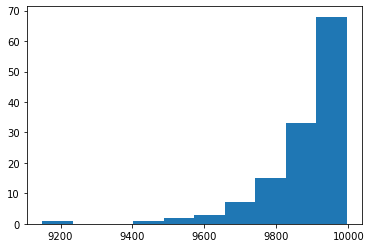

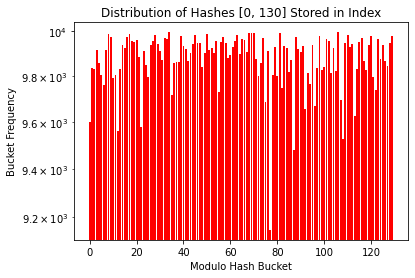

In [29]:
import random
import matplotlib.pyplot as plt
random.seed(17)

N = 10000 # sequence length 
read = ''.join([random.choice('CGTA') for i in range(N)])
kmer_size = 5 # kmer length

# Try this one out!
M = 130 # number of buckets that hashed kmer can fall into
# NOTE: number of values is N - k + 1

bucket_data = get_kmers_bucket_data(read, kmer_size, M)
# print(data)

plt.hist(bucket_data)
plt.show()

plt.bar(range(len(bucket_data)), bucket_data, color='red')
plt.xlabel('Modulo Hash Bucket')
plt.ylabel('Bucket Frequency')
plt.yscale('log')
plt.title(f"Distribution of Hashes [0, {M}] Stored in Index")
plt.show()

## Seeding

#### Seed-filter-extend (EEE) strategy
1. Indexing the genome
2. **Reads are fragmented into *seeds* that are cross referenced with the indexed genome**
3. Candidates are filtered to reduce the computational load of extension.
4. Reads are edit distance approximated using aforementioned string matching algorithms.

#### Extract non-overlapping k-mers and calculate the key to find positions
* A non-overlapping kmer of the read is passed to the modulo hash function to calculate the key to find a position
    * Both the index and read kmer appear to be the same size
* If there are no candidates, the starting position of the seed is shifted until a candidate is found
    * If this occurs, found candidate positions are also shifted to normalize the positions

#### Paired end vs single end reads
* Can handle both
* Single end reads pass all candidates to the extension (alignment) stage
* For paired end reads, a pairwise-distance threshold is used to find candidates
    * pairwise-distance threshold essentially calculates the likelihood the two sequences match
    

## Embedding

### Seed-filter-extend (EEE) strategy
1. Indexing the genome
2. Reads are fragmented into *seeds* that are cross referenced with the indexed genome
3. **Candidates are filtered to reduce the computational load of extension.**
4. Reads are edit distance approximated using aforementioned string matching algorithms.

### Important goal of embedding
* Rely on hamming distance to best approximate which string might be the best match.
* Transform the read and reference candidates so that the hamming distance between these *new strings* can help approximate the edit distance between the *old strings*.

### Two implementations
* 3N-embedding
* 2N-embedding

### 3N-embedding

![3N_embedding_pseudo](3N_embedding.png)

$S'$ is our new string that: 
* is 3 times the length of our original string
* contains padding characters

In [35]:
def three_n_embedding(S: str, r: str):
    i = 0
    N = len(S)
    P = 'P'
    output = list(3 * N * P)
    
    for j in range(N):
        if i < N:
            output[j] = S[i]
        else:
            output[j] = P
        i += int(r[j])
    
    return ''.join(output)



N = 50 # sequence length 
S = ''.join([random.choice('CGTA') for i in range(N)])
r = ''.join([random.choice('10') for i in range(3 * N)])

print(S)
print(r)

three_n_embedding(S, r)

GCGACTCAAAGACTGTGGACATCTACGTCCCCAATCGATATGTTGCACTA
111011110011111110010000011110011110010111001100101111100000010111111011101000011111101011010010000011101000011100000101111100010011100010101010110111


'GCGAACTCAAAAAGACTGGGTTTTTTGGACCCATCTTTAACGTTTCCCCCPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP'

### Let's role the dice

#### Our function from before
$D(x,y) = D_H(f(x),f(y)) / d_E(x,y)$

In [51]:
def create_string(chars: str, N: int):
    return ''.join([random.choice(chars) for i in range(N)])

def hamming_distance(S1, S2):
    # https://en.wikipedia.org/wiki/Hamming_distance
    return sum(a != b for a, b in zip(S1, S2))


N = 25
nucleotides = 'ACTG'
bits = '10'

x_str = create_string(nucleotides, N) 
y_str = create_string(nucleotides, N)

# Unit test!
# N = 4
# S1 = 'AAAA'
# S2 = 'ACTG'

r = create_string(bits, 3 * N)
# create_string(bits, 3 * N)


def calculate_distortion(f, x_str, x_r, y_str, y_r):
    return hamming_distance(f(x_str, x_r), f(y_str, y_r)) / levenshtein_distance(x_str, y_str, False)
    # return hamming_distance(f(x_str, x_r), f(y_str, y_r))


print(three_n_embedding(x_str, x_r))
print(three_n_embedding(y_str, y_r))

calculate_distortion(f = three_n_embedding, x_str = x_str, x_r = r, y_str = y_str, y_r = r)

IndexError: string index out of range

#### 2N Embedding

* 2N embedding reduces complexity by copying the input string only twice.
* This otherwise does the same task but with better performance.

![2N_embedding_pseudo](2N_embedding.png)

### Extension

#### Seed-filter-extend (EEE) strategy
1. Indexing the genome
2. Reads are fragmented into *seeds* that are cross referenced with the indexed genome
3. Candidates are filtered to reduce the computational load of extension.
4. **Reads are edit distance approximated using aforementioned string matching algorithms.**

#### The edit distance is the hamming distance of the new strings
* They refer to this as the *embedding distance*

### Rectifying positions

* INDELs can have cascading effects on positions.
* If there is an insertion in a prior seed, the start position of the next seed should be $position + 1$
    * This is similar to the start position calculations we did in Deseq using the CIGAR string
    
* They take a range of kmers from the genome that are around the first seed and find the minimum embedding distance to find the best candidate.

### Different alignment modes will effect extension
* Mapping mode 
    * Targets a region in the reference genome that has the least embedding distance

* Alignment mode
    * Base by base comparison
    * They use [libgaba](https://github.com/ocxtal/libgaba) library for full alignment 

### MAPQ calculations
* MAPQ is a score for how good the alignment is. This is actually a column we have seen in the SAM Format.
* Usually multiple candidates are extended to compare MAPQ scores.
* In their implementation, they modify Bowtie2's MAPQ algorithm to use their embedding distance calculations.
    * They compare RoC scores is their results. 

## Results


### Simulation

The authors use [Mason2](https://www.seqan.de/apps/mason.html) to generate simulated fastq reads. The [publication](http://publications.imp.fu-berlin.de/962/2/mason201009.pdf) provides a succinct introduction to their tool.

```bash
wget http://packages.seqan.de/mason2/mason2-2.0.9-Linux-x86_64.tar.xz
unxz mason2-2.0.9-Linux-x86_64.tar.xz
tar -xvf mason2-2.0.9-Linux-x86_64.tar
cd mason2-2.0.9-Linux-x86_64/bin
./mason_genome --help
```

M. Holtgrewe, “Mason – A Read Simulator for Second Generation Sequencing Data”, 2010-10

```
mason_genome - Random Genome Simulation
=======================================

SYNOPSIS
    mason_genome [OPTIONS] [-l LEN]+ -o OUT.fa

DESCRIPTION
    Simulate a random genome to the output file. For each -l/--contig-length
    entry, a contig with the given length will be simulated.

OPTIONS
    -h, --help
          Display the help message.
    --version-check BOOL
          Turn this option off to disable version update notifications of the
          application. One of 1, ON, TRUE, T, YES, 0, OFF, FALSE, F, and NO.
          Default: 1.
    --version
          Display version information.
    -q, --quiet
          Set verbosity to a minimum.
    -v, --verbose
          Enable verbose output.
    -vv, --very-verbose
          Enable very verbose output.

  Simulation Configuration:
    -l, --contig-length List of INTEGER's
          Length of the contig to simulate. Give one -l value for each contig
          to simulate. In range [1..inf].
    -s, --seed INTEGER
          The seed to use for the random number generator. Default: 0.

  Output Options:
    -o, --out-file OUTPUT_FILE
          Output file. Valid filetypes are: .sam[.*], .raw[.*], .frn[.*],
          .fq[.*], .fna[.*], .ffn[.*], .fastq[.*], .fasta[.*], .faa[.*],
          .fa[.*], and .bam, where * is any of the following extensions: gz
          and bgzf for transparent (de)compression.

EXAMPLES
    mason_genome -l 1000 -l 4000 -o genome.fa
          Simulate a genome with two contigs of lengths 1000 and 4000 and
          write it to genome.fa.

VERSION
    Last update: 2018-02-02_13:03:05_+0100
    mason_genome version: 2.0.9 [e165baf]
    SeqAn version: 2.4.0
```

### Benchmarking different aligners

![figure_2](benchmarking.jpg)

Correctly mapped is 10% of read length

### RoC Curves

![Roc](Fig2_HTML.jpg)

### Comparison using varying read lengths

![figure 3](Fig3_HTML.jpg)

![read_lengths](read_lengths.jpg)

### Alignment Free Mapping Comparison 

![figure3](Fig3_HTML.jpg)

![figure4](Fig4_HTML.jpg)

### Impact of embedding

![impact_embedding](embedding_impact.jpg)

### Benchmarking with real data

![figure5](Fig5_HTML.jpg)

**A** Accel-Align
</br>
**B** BWA-MEM
</br>
**C** Minimap2
</br>
**D** Bowtie2
</br>
**E** Subread
</br>


![real](real_data.jpg)

* Ti/Tv - transition-to-transversion ration (2.7-3.3), a metric for SNV detection 
* Precision - The number of true positives over all retrieved matches
* Recall - The number of true positives identified over the number of actual matches (includes false negatives)
* F-Score - Calculation of accuracy using precision and accuracy


### Kmer Size on Accuracy

* Remember that they used 32-mers
* They adjusted to 25-mers and tested their accuracy
    * The reason for this is to increase performance

![figure6](Fig6_HTML.jpg)

* They still have 2-6x better execution time despite increased seeding, and they credit embedding for this

### Indel and SNP Detection

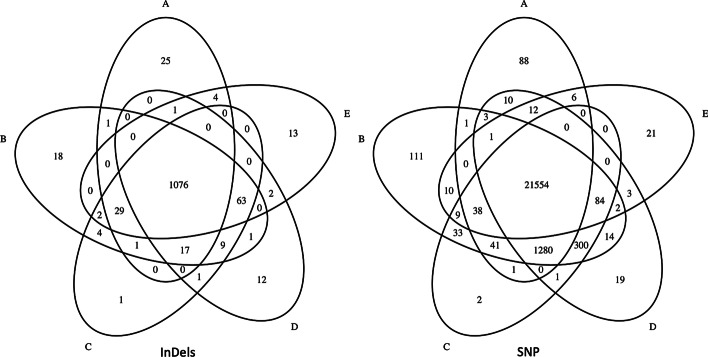

**A** Accel-Align
</br>
**B** BWA-MEM
</br>
**C** Minimap2
</br>
**D** Bowtie2
</br>
**E** Subread
</br>

![fig9](Fig9_HTML.jpg)

![snp_indel_table](real_data.jpg)

* A majority of indels were discovered, and many missed were shorter reads in length   

## Discussion

* What other areas in bioinformatics may need to be optimized due to increased read sizes or data in general?

* Are there tests that were missed by that would have made their argument more effective?

### Compile Instructions

```bash
jupyter nbconvert presentation.ipynb --to slides --post serve --SlidesExporter.reveal_scroll=True
```